# Colab

In [ ]:
!nvidia-smi -L  

GPU 0: Tesla K80 (UUID: GPU-c3c33697-3444-ca90-a5aa-54daac1e9f05)


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!rm -r sample_data

In [ ]:
!pip install timm

     |████████████████████████████████| 431 kB 5.4 MB/s 


# Parameters

In [ ]:
import torch
import timm
import pandas as pd

print("torch_version: " + torch.__version__)
print("timm_version: " + timm.__version__)
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
torch.__version__, DEVICE

torch_version: 1.10.0+cu111
timm_version: 0.5.4


('1.10.0+cu111', 'cuda')

In [ ]:
params = {
    # "model": "vit_large_patch16_224",
    "model": "resnet18",
    "device": "cuda" if torch.cuda.is_available() else "cpu",
    "im_size": 224,
    "lr": 1e-3,
    "batch_size": 32,
    "num_workers": 2,
    "epochs": 20,
    "folds":3,
    "lr_scheduler": True,
    "early_stopping": True,
    "augmentation": False,
    "targets_exist": False,
    "diagnosis": True, # if True, multiclass will be performed, else binary classification
    "path": "/content/drive/MyDrive/ISIC/2020"
}
PATH = params['path']

# Handle csv | Meta data

## csv

In [ ]:
import os
os.listdir(PATH)

['ISIC_2020_Training_GroundTruth.csv',
 'ISIC_2020_Training_JPEG.zip',
 'ISIC_2020_Training_Metadata.csv',
 'ISIC_2020_Test_Metadata.csv',
 'ISIC_2020_Test_JPEG.zip',
 'siim-isic-melanoma-classification.zip',
 'Training_GroundTruth.csv',
 'Test_Metadata.csv',
 'train',
 'splits',
 'fold',
 'test',
 'test_meta.csv',
 'train_meta.csv',
 'val_split_meta.csv',
 'train_split_meta.csv',
 'subset_meta.csv',
 'submission.csv',
 'submission_sigmoid.csv',
 'test_path.csv',
 'val_split.csv',
 'train_split.csv',
 'subset.csv']

In [ ]:
import pandas as pd
train_csv = f'{PATH}/Training_GroundTruth.csv'
test_csv = f'{PATH}/Test_Metadata.csv'

train = pd.read_csv(train_csv)
test = pd.read_csv(test_csv)

## Add path to csv

In [ ]:
def to_path(image_name, path):
  return path + image_name + '.jpg'

In [ ]:
train_path = f'{PATH}/train/'
test_path = f'{PATH}/test/'

In [ ]:
train['path'] = train.image_name.apply(to_path, path = train_path)

test['path'] = test.image.apply(to_path, path=test_path)

test.to_csv(f'{PATH}/test_path.csv', index=False)

In [ ]:
train.shape, test.shape

((33126, 9), (10982, 6))

## Add diagnosis as target

In [ ]:
train['diagnosis'].value_counts()

unknown                               27124
nevus                                  5193
melanoma                                584
seborrheic keratosis                    135
lentigo NOS                              44
lichenoid keratosis                      37
solar lentigo                             7
cafe-au-lait macule                       1
atypical melanocytic proliferation        1
Name: diagnosis, dtype: int64

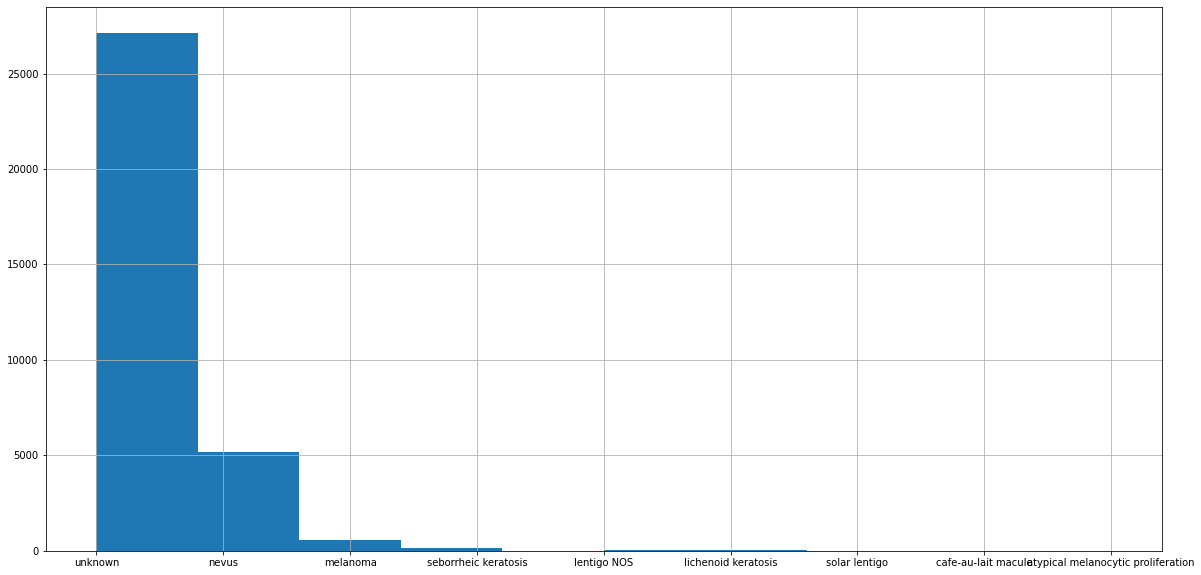

In [ ]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize = (20,10))
ax = fig.gca()
train['diagnosis'].hist(ax = ax)

### Mapping

2020 seborrheic keratosis -> BKL

2020 lichenoid keratosis -> BKL

2020 solar lentigo -> BKL

2020 lentigo NOS -> BKL

2020 cafe-au-lait macule -> unknown

2020 atypical melanocytic proliferation -> unknown

2020 nevus -> NV

2020 melanoma -> MEL

-----

unknown                               27124

nevus                                  5193

melanoma                                584

seborrheic keratosis                    135

lentigo NOS                              44

lichenoid keratosis                      37

solar lentigo                             7

cafe-au-lait macule                       1

atypical melanocytic proliferation        1

In [ ]:
train['diagnosis']  = train['diagnosis'].apply(lambda x: x.replace('seborrheic keratosis', 'BKL'))
train['diagnosis']  = train['diagnosis'].apply(lambda x: x.replace('lichenoid keratosis', 'BKL'))
train['diagnosis']  = train['diagnosis'].apply(lambda x: x.replace('solar lentigo', 'BKL'))
train['diagnosis']  = train['diagnosis'].apply(lambda x: x.replace('lentigo NOS', 'BKL'))
train['diagnosis']  = train['diagnosis'].apply(lambda x: x.replace('cafe-au-lait macule', 'UNK'))
train['diagnosis']  = train['diagnosis'].apply(lambda x: x.replace('atypical melanocytic proliferation', 'UNK'))
train['diagnosis']  = train['diagnosis'].apply(lambda x: x.replace('unknown', 'UNK'))

train['diagnosis'] = train['diagnosis'].apply(lambda x: x.replace('nevus', 'NV'))
train['diagnosis'] = train['diagnosis'].apply(lambda x: x.replace('melanoma', 'MEL'))

In [ ]:
train['diagnosis'].value_counts()

UNK    27126
NV      5193
MEL      584
BKL      223
Name: diagnosis, dtype: int64

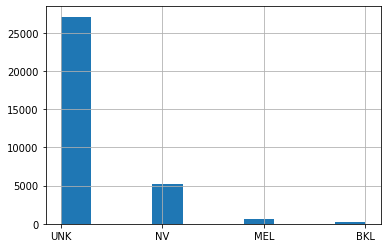

In [ ]:
train['diagnosis'].hist()

In [ ]:
diagnosis_idx = {d: idx for idx, d in enumerate(sorted(train.diagnosis.unique()))}
train['target'] = train['diagnosis'].map(diagnosis_idx)
# train['target'] = train['diagnosis'].replace(['BKL','MEL','NV','UNK'],[0,1,2,3])

### Train Exploration

#### Diagnosis histogram

81.88733925013585
15.676507879007426
UNK    27126
NV      5193
MEL      584
BKL      223
Name: diagnosis, dtype: int64


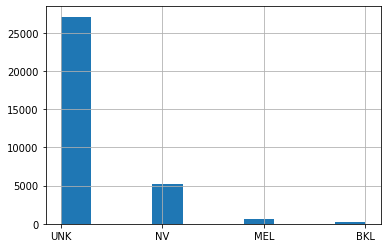

In [ ]:
print(train['diagnosis'].value_counts()[0]/len(train['diagnosis'])*100)
print(train['diagnosis'].value_counts()[1]/len(train['diagnosis'])*100)

print(train['diagnosis'].value_counts())
train['diagnosis'].hist()

#### Target histogram

0.6731872245366177
1.762965646320111
3    27126
2     5193
1      584
0      223
Name: target, dtype: int64


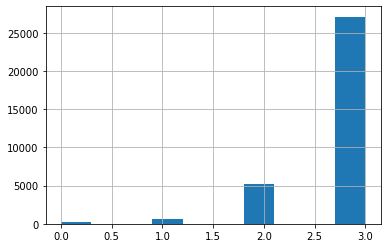

In [ ]:
print(train['target'].value_counts()[0]/len(train['target'])*100)
print(train['target'].value_counts()[1]/len(train['target'])*100)

print(train['target'].value_counts())
train['target'].hist()

#### Genre histogram

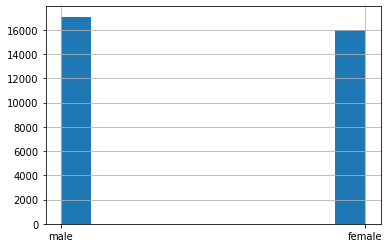

In [ ]:
try:
  train['sex'].hist()
except:
  print("not found in dataframe")
   

#### Age histogram

In [ ]:
try:
  train['age_approx'].value_counts()
except:
  print("not found in dataframe")

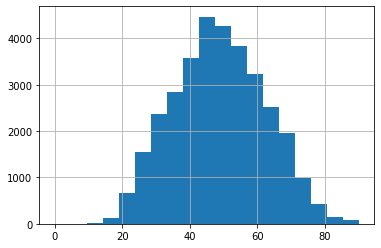

In [ ]:
try:
  train['age_approx'].hist(bins=len(train['age_approx'].unique()))
except:
  print("not found in dataframe")

#### Anatom site

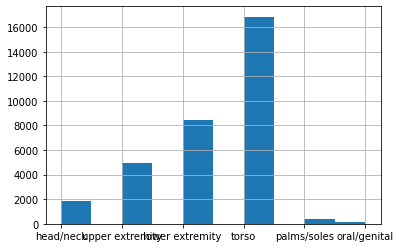

In [ ]:
try:
  train['anatom_site_general_challenge'].hist()
except:
  print("not found in dataframe")

## Meta data

In [ ]:
train_meta = train
test_meta = test

### Meta exploration

In [ ]:
train_meta.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33126 entries, 0 to 33125
Data columns (total 9 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   image_name                     33126 non-null  object 
 1   patient_id                     33126 non-null  object 
 2   sex                            33061 non-null  object 
 3   age_approx                     33058 non-null  float64
 4   anatom_site_general_challenge  32599 non-null  object 
 5   diagnosis                      33126 non-null  object 
 6   benign_malignant               33126 non-null  object 
 7   target                         33126 non-null  int64  
 8   path                           33126 non-null  object 
dtypes: float64(1), int64(1), object(7)
memory usage: 2.3+ MB


In [ ]:
test_meta.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10982 entries, 0 to 10981
Data columns (total 6 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   image                10982 non-null  object
 1   patient              10982 non-null  object
 2   age_approx           10982 non-null  int64 
 3   anatom_site_general  10631 non-null  object
 4   sex                  10982 non-null  object
 5   path                 10982 non-null  object
dtypes: int64(1), object(5)
memory usage: 514.9+ KB


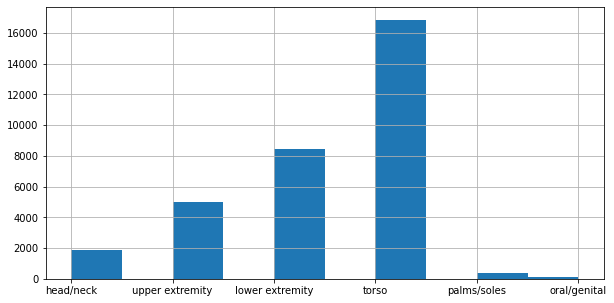

In [ ]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize = (10,5))
ax = fig.gca()
train_meta['anatom_site_general_challenge'].hist(ax=ax)

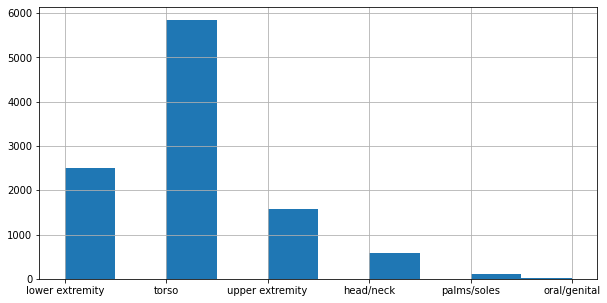

In [ ]:
fig = plt.figure(figsize = (10,5))
ax = fig.gca()
test_meta['anatom_site_general'].hist(ax = ax)

### Explore NaN values

In [ ]:
nans_train = train_meta.isna().sum()
nans_test = test_meta.isna().sum()
print(nans_train)
print("\n")
print(nans_test)

image_name                         0
patient_id                         0
sex                               65
age_approx                        68
anatom_site_general_challenge    527
diagnosis                          0
benign_malignant                   0
target                             0
path                               0
dtype: int64


image                    0
patient                  0
age_approx               0
anatom_site_general    351
sex                      0
path                     0
dtype: int64


Check NaNs by ID

In [ ]:
train_meta['anatom_site_general_challenge'].isnull()

0        False
1        False
2        False
3        False
4        False
         ...  
33121    False
33122    False
33123    False
33124    False
33125    False
Name: anatom_site_general_challenge, Length: 33126, dtype: bool

In [ ]:
null_df = train_meta[train_meta.isnull().any(axis=1)]

In [ ]:
null_df[null_df['patient_id'] == 'IP_8794667']

,image_name,patient_id,sex,age_approx,anatom_site_general_challenge,diagnosis,benign_malignant,target,path
780,ISIC_0338752,IP_8794667,male,55.0,NaN,UNK,benign,3,/content/drive/MyDrive/ISIC/2020/train/ISIC_03...
16542,ISIC_5061278,IP_8794667,male,55.0,NaN,UNK,benign,3,/content/drive/MyDrive/ISIC/2020/train/ISIC_50...


In [ ]:
for i in range(len(null_df['patient_id'].unique())):
  id = null_df['patient_id'].unique()[i]
  value = null_df['patient_id'].value_counts()[i]
  print(id,'=',value,'\n',null_df.groupby(['patient_id'])['age_approx'].get_group(id).value_counts().to_frame(),'\n')


IP_3200260 = 102 
       age_approx
30.0           1 

IP_5205991 = 48 
 Empty DataFrame
Columns: [age_approx]
Index: [] 

IP_3057277 = 30 
       age_approx
45.0         102 

IP_2760044 = 17 
       age_approx
40.0           2 

IP_4248414 = 14 
       age_approx
25.0           1 

IP_5549010 = 11 
       age_approx
30.0           2 

IP_0550106 = 9 
 Empty DataFrame
Columns: [age_approx]
Index: [] 

IP_4645992 = 5 
       age_approx
35.0           2 

IP_0400826 = 5 
       age_approx
45.0          30 

IP_4702665 = 5 
       age_approx
65.0          11 

IP_9835712 = 4 
 Empty DataFrame
Columns: [age_approx]
Index: [] 

IP_8794667 = 4 
       age_approx
55.0           2 

IP_8839187 = 4 
       age_approx
25.0           1 

IP_0507923 = 4 
       age_approx
25.0           1
30.0           1 

IP_2661172 = 4 
       age_approx
45.0           3 

IP_6512345 = 4 
       age_approx
70.0           2 

IP_7375528 = 4 
       age_approx
55.0           2 

IP_2632866 = 4 
       age_approx

In [ ]:
train_meta.patient_id[train_meta['sex']==train_meta.isnull()]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: Automatic reindexing on DataFrame vs Series comparisons is deprecated and will raise ValueError in a future version.  Do `left, right = left.align(right, axis=1, copy=False)` before e.g. `left == right`
  """Entry point for launching an IPython kernel.


In [ ]:
null_df[null_df['sex'].isnull()]

In [ ]:
null_df.groupby(['patient_id'])['sex'].value_counts()

In [ ]:
train_meta.shape

In [ ]:
train_sex = train_meta[(train_meta['sex'] != 'male') & (train_meta['sex'] != 'female')]
train_sex['patient_id'].value_counts()

In [ ]:
train_sex['age_approx'].isna().sum()

In [ ]:
train_meta.groupby('patient_id')['sex'].value_counts().to_frame()

### Handle NaN values (basic)

#### Creating n_images

In [ ]:
train_meta['n_images'] = train_meta.groupby('patient_id').cumcount().add(1).astype(str).to_frame()
train_meta

##### Train

In [ ]:
train_meta['sex'] = train_meta['sex'].fillna('unknown')
train_meta['sex'].value_counts()

#### Age_approx

In [ ]:
train_meta.age_approx= train_meta.age_approx.fillna(0.0).astype(int)
train_meta = train_meta.astype({"age_approx": 'str'})

train_meta['age_approx'] = train_meta['age_approx'].fillna('unknown')
print("Missing values? -> ",train_meta['age_approx'].isna().any())
train_meta['age_approx'].value_counts()

In [ ]:
test_meta = test_meta.astype({"age_approx": 'str'})

#### Sex

In [ ]:
train_meta['sex'] = train_meta['sex'].fillna('unknown')
print("Missing values? -> ",train_meta['sex'].isna().any())
train_meta['sex'].value_counts()

#### anatom_site

##### Train

In [ ]:
train_meta['anatom_site_general_challenge'] = train_meta['anatom_site_general_challenge'].fillna('unknown')
print("Missing values? -> ",train_meta['anatom_site_general_challenge'].isna().any())
train_meta['anatom_site_general_challenge'].value_counts()

##### Test

In [ ]:
test_meta['anatom_site_general'] = test_meta['anatom_site_general'].fillna('unknown')
print("Missing values? -> ",test_meta['anatom_site_general'].isna().any())
test_meta['anatom_site_general'].value_counts()

### Encode Metadata

In [ ]:
train_meta.shape, test_meta.shape

In [ ]:
from sklearn.preprocessing import OneHotEncoder

#### train

In [ ]:
hot_enconder = OneHotEncoder()

train_columns = train_meta.columns[2], train_meta.columns[3], train_meta.columns[4]
train_columns =list(train_columns)
hot_enconder.fit(train_meta[train_columns])
hot_enconder.categories_

In [ ]:
hot_enconder.transform([['female', '10','upper extremity']]).toarray()

#### Test

In [ ]:
hot_enconder_test = OneHotEncoder()
test_columns = test_meta.columns[4], test_meta.columns[2], test_meta.columns[3]
test_columns = list(test_columns)
hot_enconder_test.fit(test_meta[test_columns])
hot_enconder_test.categories_

#### Create csv

In [ ]:
train_meta.to_csv(f'{PATH}/train_meta.csv',index=False)
test_meta.to_csv(f'{PATH}/test_meta.csv',index=False)

## Hold-out with stratify for training

In [ ]:
from sklearn.model_selection import train_test_split

train_split, val_split = train_test_split(train, random_state=42, test_size=0.33, shuffle=True, stratify=train['target'])
train_split.shape, val_split.shape

In [ ]:
train_split.to_csv(f'{PATH}/train_split.csv', index=False)
val_split.to_csv(f'{PATH}/val_split.csv', index=False)

## Meta

In [ ]:
from sklearn.model_selection import train_test_split

train_split_meta, val_split_meta = train_test_split(train_meta, random_state=42, test_size=0.33, shuffle=True, stratify=train_meta['target'])
train_split_meta.shape, val_split_meta.shape

In [ ]:
train_split_meta.to_csv(f'{PATH}/train_split_meta.csv', index=False)
val_split_meta.to_csv(f'{PATH}/val_split_meta.csv', index=False)

### Exploration of split distrubition

#### train split

In [ ]:
print(train_split['target'].value_counts()[0]/len(train['target'])*100)
print(train_split['target'].value_counts()[1]/len(train['target'])*100)

print(train_split['target'].value_counts())
train_split['target'].hist()

#### val split

In [ ]:
print(val_split['target'].value_counts()[0]/len(train['target'])*100)
print(val_split['target'].value_counts()[1]/len(train['target'])*100)

print(val_split['target'].value_counts())
val_split['target'].hist()

# Subset

## Create subset

In [ ]:
_, subset = train_test_split(train_split, random_state=42, test_size=0.1, shuffle=True, stratify=train_split['target'])
subset.shape

In [ ]:
subset.to_csv(f'{PATH}/subset.csv', index=False)

## Meta

In [ ]:
_, subset_meta = train_test_split(train_split_meta, random_state=42, test_size=0.1, shuffle=True, stratify=train_split_meta['target'])
subset_meta.shape

In [ ]:
subset_meta.to_csv(f'{PATH}/subset_meta.csv', index=False)

### Exploration distrubution of subset

In [ ]:
print(subset['target'].value_counts()[0]/len(subset['target'])*100)
print(subset['target'].value_counts()[1]/len(subset['target'])*100)

print(subset['target'].value_counts())
subset['target'].hist()

# Folds

## Create csv with folds

In [ ]:
import numpy as np
from sklearn import model_selection
KFOLD = params['folds']
kf = model_selection.StratifiedKFold(n_splits=KFOLD, random_state=42, shuffle=True)
for fold_, (train_idx, val_idx) in enumerate(kf.split(X=train,y=train['target'])):
  train.loc[val_idx,'kfold'] = fold_
  train.to_csv(f'{PATH}/train_fold{KFOLD}.csv')
  print("Fold:",fold_+1)
  print(train_idx.shape, val_idx.shape)

# Load csv

## Hold-out split

In [ ]:
train_csv = f'{PATH}/train_split.csv'
val_csv = f'{PATH}/val_split.csv'

train = pd.read_csv(train_csv)
val = pd.read_csv(val_csv)
train.shape, val.shape

## Stratified kFolds 

In [ ]:
KFOLD= params['folds']
train_csv = f'{PATH}/train_fold{KFOLD}.csv'
train = pd.read_csv(train_csv)

## Subset csv load

In [ ]:
train_csv = f'{PATH}/subset.csv'
val_csv = f'{PATH}/val_split.csv'

train = pd.read_csv(train_csv)
val = pd.read_csv(val_csv)
train.shape, val.shape

((2220, 9), (10932, 9))

## Meta subset load

In [ ]:
train = pd.read_csv(f'{PATH}/subset_meta.csv')
val = pd.read_csv(f'{PATH}/val_split_meta.csv')

train = train.astype({"age_approx": 'str'})
val = val.astype({"age_approx": 'str'})

train.shape, val.shape

# Dataset.py | Metadata

In [ ]:
import os
import cv2
import numpy as np
import albumentations
import torch
from torch.utils.data import Dataset

In [ ]:
class MelanomaDataset(Dataset):
  def __init__(self, images, labels=None, transform=None, train=True):
    self.images = images
    self.labels = labels
    self.transform = transform
    self.train = train

  def __getitem__(self, index):
    image = cv2.imread(self.images[index])
    target = torch.tensor([self.labels[index]])
    if self.transform is not None:
      image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
      # image = self.transform(image=image)["image"].astype(np.float32)/255.
      # image = self.transform(image=image)["image"].astype(np.float32)
      image = self.transform(image=image)["image"]
      # image = image.transpose(2, 0, 1)/255.
      image = image.transpose(2, 0, 1)
    else:
      image = cv2.resize(image, (params['im_size'],params['im_size']))
      image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
      image = image/ 255.
      image = image.transpose(2, 0, 1)
    if self.train:
      return torch.tensor(image).float(), target.float()
    return torch.tensor(image).float()

  def __len__(self) -> int:
    return len(self.images)

## Meta dataset

In [ ]:
# from skimage import io
# from skimage.transform import resize

from skimage import io
from skimage.transform import resize

class MelanomaDatasetMeta(Dataset):
  def __init__(self, images, meta, labels=None, transform=None, train=True):
    self.images = images
    self.labels = labels
    self.transform = transform
    self.train = train
    meta = hot_enconder.transform(meta).toarray()
    self.meta = meta

  def __getitem__(self, index):
    image = cv2.imread(self.images[index])
    meta = torch.tensor(self.meta[index])
    if self.transform is not None:
      image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
      # image = self.transform(image=image)["image"].astype(np.float32)/255.
      # image = self.transform(image=image)["image"].astype(np.float32)
      image = self.transform(image=image)["image"]
      # image = image.transpose(2, 0, 1)/255.
      image = image.transpose(2, 0, 1)
    else:
      image = cv2.resize(image, (params['im_size'],params['im_size']))
      image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
      image = image/ 255.
      image = image.transpose(2, 0, 1)
    image = torch.tensor(image)
    if self.train:      
      target = torch.tensor([self.labels[index]])
      return image.float(), meta.float(), target.float()
    return image.float(), meta.float()
  
  # def load_img(self, img):
  #   im = io.imread(img)
  #   return resize(im,(256,256))

  # def __getitem__(self, ix):
  #   img = self.load_img(self.images[ix])
  #   img = img.transpose(2, 0, 1)
  #   data = torch.from_numpy(img).float()
  #   target = torch.tensor([self.labels[ix]]).float()
  #   return data, target

  def __len__(self) -> int:
    return len(self.images)

# Calculate mean and std

## Method 1

In [ ]:
def get_mean_and_std(dataloader):
    channels_sum, channels_squared_sum, num_batches = 0, 0, 0
    for data, _ in dataloader:
      channels_sum += torch.mean(data, dim=[0,2,3])
      channels_squared_sum += torch.mean(data**2, dim=[0,2,3])
      num_batches += 1
    mean = channels_sum / num_batches
    std = (channels_squared_sum / num_batches - mean ** 2) ** 0.5
    return tuple(mean.numpy()), tuple(std.numpy())

In [ ]:
mean, std = get_mean_and_std(DataLoader(MelanomaDataset(train['path'], train['target'])))
print(mean)
print(std)

## Method 2

In [ ]:
#use this training model from scratch or not using pretrained model
from tqdm import tqdm
def compute_img_mean_std(image_paths):
    '''
    normalising data from 0-255 to 0-1
    mean and std of three channnel
    '''
    img_h, img_w = 224,224
    imgs = []
    means, stds = [],[]
    #resizing 
    for i in tqdm(image_paths):
        img = cv2.imread(i)
        img.resize(img_w,img_h)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        imgs.append(img)
        
    # (224,224,3),nof_img -> 224,224,3,nof_img
    imgs = np.stack(imgs, axis=3)
    #normalising 
    imgs=imgs.astype(np.float32)/255.
    
    print(imgs.shape)
    #mean and std of each channel
    for i in range(3):
        pixels = imgs[:,:,i,:].ravel() #resizing to one row
        mean = pixels.mean()
        std = pixels.std()
        
        means.append(mean)
        stds.append(std)
        
    means.reverse() #bgr to rgb
    stds.reverse()
    
    return means, stds

In [ ]:
compute_img_mean_std(train['path'])

## Method 3

In [ ]:
# placeholders
psum    = torch.tensor([0.0, 0.0, 0.0])
psum_sq = torch.tensor([0.0, 0.0, 0.0])

# loop through images
for inputs,_ in tqdm(DataLoader(MelanomaDataset(train['path'], train['target']))):
    psum    += inputs.sum(axis        = [0, 2, 3])
    psum_sq += (inputs ** 2).sum(axis = [0, 2, 3])

In [ ]:
# pixel count
count = len(train['path']) * params['im_size'] * params['im_size']

# mean and std
total_mean = psum / count
total_var  = (psum_sq / count) - (total_mean ** 2)
total_std  = torch.sqrt(total_var)

# output
print('mean: '  + str(total_mean))
print('std:  '  + str(total_std))


# Augmentation

In [ ]:
mean= (0.7232643, 0.6180579, 0.56661755)

std= (0.16529222, 0.1724447, 0.19304909)

In [ ]:
import albumentations as A

def transform_aug(im_size):
  transforms_train = A.Compose(
      [
       A.Transpose(p=0.5),
       A.VerticalFlip(p=0.5),
       A.HorizontalFlip(p=0.5),
       A.RandomBrightness(limit=0.2, p=0.75),
       A.RandomContrast(limit=0.2, p=0.75),
       A.OneOf([
                A.MotionBlur(blur_limit=5),
                A.MedianBlur(blur_limit=5),
                A.Blur(blur_limit=5),
                A.GaussNoise(var_limit=(5.0, 30.0)),
                ], p=0.7),
       A.OneOf([
                A.OpticalDistortion(distort_limit=1.0),
                A.GridDistortion(num_steps=5, distort_limit=1.),
                A.ElasticTransform(alpha=3),
                ], p=0.7),
       A.CLAHE(clip_limit=4.0, p=0.7),
       A.HueSaturationValue(hue_shift_limit=10, sat_shift_limit=20, val_shift_limit=10, p=0.5),
       A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.1, rotate_limit=15, border_mode=0, p=0.85),
       A.Resize(im_size, im_size),
       A.Cutout(max_h_size=int(im_size * 0.375), max_w_size=int(im_size * 0.375), num_holes=1, p=0.7),
       A.Normalize(mean = (0.7232643, 0.6180579, 0.56661755),std = (0.16529222, 0.1724447, 0.19304909))
       ])
  transforms_val = A.Compose(
      [
       A.SmallestMaxSize(max_size=160),
       A.CenterCrop(height=128, width=128),
       A.Resize(im_size, im_size),
       A.Normalize(mean = (0.7232643, 0.6180579, 0.56661755),std = (0.16529222, 0.1724447, 0.19304909))
       ])
  return transforms_train, transforms_val

# Metrics

In [ ]:
from collections import defaultdict
class MetricMonitor:
  def __init__(self, float_precision=3):
    self.float_precision = float_precision
    self.reset()
    
  def reset(self):
    self.metrics = defaultdict(lambda: {"val": 0, "count": 0, "avg": 0})

  def update(self, metric_name, val):
    metric = self.metrics[metric_name]

    metric["val"] += val
    metric["count"] += 1
    metric["avg"] = metric["val"] / metric["count"]

  def get(self, metric_name):
    return self.metrics.get(metric_name).get('avg')
    
  def __str__(self):
    return " | ".join(
        ["{metric_name}: {avg:.{float_precision}f}".format(metric_name=metric_name,
                                                           avg=metric["avg"],
                                                           float_precision=self.float_precision)
        for (metric_name, metric) in self.metrics.items()])

In [ ]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_curve
from sklearn.metrics import average_precision_score
from sklearn.metrics import confusion_matrix
import seaborn as sn

threshold = 0.5

def auc_score(outputs, targets):
  # outputs = torch.sigmoid(outputs)
  outputs = outputs.cpu().detach().numpy()
  targets = targets.cpu().detach().numpy()
  auc = roc_auc_score(targets, outputs)
  return auc

def auc_score_m(outputs, targets, multi_class='ovr'):
  outputs = outputs.cpu()
  outputs = nn.functional.softmax(outputs, dim=1)
  outputs = outputs.detach().numpy()
  targets = targets.cpu().detach().numpy()
  auc = roc_auc_score(targets, outputs, multi_class=multi_class)
  return auc

def f1_score_(outputs, targets):
  outputs = outputs >= threshold
  # outputs = outputs >= 0.0
  targets = targets == 1.0
  outputs = outputs.cpu().detach().numpy()
  targets = targets.cpu().detach().numpy()
  f1 = f1_score(targets, outputs, average='weighted')
  return f1

def f1_score_m(outputs, targets):
  outputs = outputs.cpu()
  outputs = nn.functional.softmax(outputs, dim=1)
  _, outputs = torch.max(outputs, dim = 1)  
  outputs = outputs.detach().numpy()
  targets = targets.cpu().detach().numpy()
  f1 = f1_score(targets, outputs, average='weighted')
  return f1

def recall_scr(outputs, targets, pos_label = 1):
  outputs = outputs >= threshold
  # outputs = outputs >= 0.0
  targets = targets == 1.0
  outputs = outputs.cpu().detach().numpy()
  targets = targets.cpu().detach().numpy()
  recall = recall_score(targets, outputs, pos_label=pos_label)
  return recall

def preicision_score(outputs, targets):
  outputs = outputs >= threshold
  # outputs = outputs >= 0.0
  targets = targets == 1.0
  outputs = outputs.cpu().detach().numpy()
  targets = targets.cpu().detach().numpy()
  preicision = average_precision_score(targets, outputs)
  return preicision

def accuracy_score(outputs, targets):
  # output = torch.sigmoid(outputs) >= 0.5
  outputs = outputs >= threshold
  # outputs = outputs >= 0.0
  targets = targets == 1.0
  return torch.true_divide((targets == outputs).sum(dim=0), outputs.size(0)).item()

def accuracy_score_m(outputs, targets):
    outputs = torch.log_softmax(outputs, dim = 1)
    _, outputs = torch.max(outputs, dim = 1)    
    preds = (outputs == targets).float()
    acc = preds.sum() / len(preds)
    return acc

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

def save_roc_curve(outputs, targets, path, label, plot=False,pos_label=1):
  outputs = outputs.cpu().detach().numpy()
  targets = targets.cpu().detach().numpy()
  false_positive_rate, true_positive_rate, thresholds = roc_curve(targets, outputs, pos_label=pos_label)
  plt.plot(false_positive_rate[2],true_positive_rate[2],color="darkorange",label="ROC curve (area = %0.2f)" % roc_auc_score(targets, outputs))
  plt.plot(false_positive_rate, true_positive_rate, lw=2, color='darkorange')
  plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")
  plt.xlim([-0.05, 1.05])
  plt.ylim([0.0, 1.05])
  plt.savefig(f"{path}/folds/{label}.png")
  plt.legend(loc="lower right")
  plt.title('Receiver operating characteristic ROC')
  plt.show() if plot else plt.close()
  plt.clf()

def save_roc_curve_m(outputs, targets, path, label, pos_label, plot=False, multi_class='ovr'):
  outputs = outputs.cpu()
  outputs = nn.functional.softmax(outputs, dim=1)
  _, outputs_ = torch.max(outputs, dim = 1)  
  outputs = outputs.detach().numpy()
  targets = targets.cpu().detach().numpy()
  false_positive_rate, true_positive_rate, thresholds = roc_curve(targets, outputs_.detach().numpy(), pos_label=pos_label)
  auc = roc_auc_score(targets, outputs, multi_class='ovr')
  plt.plot(false_positive_rate[2],true_positive_rate[2],color="darkorange",label="ROC curve (area = %0.2f)" % auc)
  plt.plot(false_positive_rate, true_positive_rate, lw=2, color='darkorange')
  plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")
  plt.xlim([-0.05, 1.05])
  plt.ylim([0.0, 1.05])
  plt.savefig(f"{path}/{label}.png")
  plt.legend(loc="lower right")
  plt.title('Receiver operating characteristic ROC')
  plt.show() if plot else plt.close()
  plt.clf()

def save_roc_curve(outputs, targets, path, label, pos_label, plot=False, multi_class='ovr'):
  outputs = outputs.cpu().detach().numpy()
  targets = targets.cpu().detach().numpy()
  false_positive_rate, true_positive_rate, thresholds = roc_curve(targets, outputs, pos_label=pos_label)
  plt.plot(false_positive_rate[2],true_positive_rate[2],color="darkorange",label="ROC curve (area = %0.2f)" % roc_auc_score(targets, outputs, multi_class=multi_class))
  plt.plot(false_positive_rate, true_positive_rate, lw=2, color='darkorange')
  plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")
  plt.xlim([-0.05, 1.05])
  plt.ylim([0.0, 1.05])
  plt.savefig(f"{path}/folds/{label}.png")
  plt.legend(loc="lower right")
  plt.title('Receiver operating characteristic ROC')
  plt.show() if plot else plt.close()
  plt.clf()

def save_confusion_matrix(outputs, targets, path, label, classes=None, plot=False, percentage=True):
  outputs = outputs.cpu().detach().numpy()
  targets = targets.cpu().detach().numpy()
  cf_matrix = confusion_matrix(targets, outputs)
  df_cm = pd.DataFrame(cf_matrix/np.sum(cf_matrix) if percentage else cf_matrix, index = [i for i in classes], columns = [i for i in classes])
  sn.heatmap(df_cm, annot=True, cmap='Blues')
  plt.title(f'{label} Confusion Matrix')
  plt.savefig(f'{path}/folds/{label}_cm.png')
  plt.show() if plot else plt.close()
  plt.clf()

# Learning rate scheduler | Early stopping

## Learning rate scheduler

In [ ]:
from torch.optim.lr_scheduler import ReduceLROnPlateau
class LRSchedulerPlateau():
  def __init__(self, optimizer, patience_t=1, mode="min", factor=0.8, min_lr=1e-7):
    self.optimizer = optimizer
    self.patience_t = patience_t
    self.mode = mode
    self.factor = factor
    self.min_lr = min_lr
    self.lr_scheduler = ReduceLROnPlateau( self.optimizer, mode='min', patience=self.patience_t, factor=self.factor, min_lr=self.min_lr, verbose=True)
  def __call__(self, val_loss):
    self.lr_scheduler.step(val_loss)

## Early stopping

In [ ]:
class EarlyStopping():
  def __init__(self, patience=5, min_delta=0.0):
    self.patience = patience
    self.min_delta = min_delta
    self.counter = 0
    self.best_loss = None
    self.early_stop = False
  def __call__(self, val_loss):
    if self.best_loss == None:
      self.best_loss = val_loss
    elif self.best_loss - val_loss > self.min_delta:
      self.best_loss = val_loss
      self.counter = 0
    elif self.best_loss - val_loss < self.min_delta:
      self.counter += 1
      print(f"INFO: Early stopping counter {self.counter} of {self.patience}")
    if self.counter >= self.patience:
      print('INFO: Early stopping')
      self.early_stop = True

# Model

In [ ]:
import timm
import torch.nn as nn
class MelanomaClassifier(nn.Module):
    def __init__(self, model_arch, n_class, pretrained=False):
        super().__init__()
        self.model = timm.create_model(model_arch, pretrained=pretrained, num_classes = n_class)
    def forward(self, x):
        x = self.model(x)
        return x
    def get_classifier(self):
        return self.model.get_classifier()
    def fc(self):
        return self.model.fc()

## Meta model

In [ ]:
import timm
import torch.nn as nn
class MelanomaClassifierMeta(nn.Module):
    def __init__(self, model_arch, n_class, pretrained=False, num_meta_inputs = 28):
        super().__init__()
        n_features = timm.create_model(model_arch, pretrained=pretrained, num_classes = n_class).get_classifier().in_features
        self.model = timm.create_model(model_arch, pretrained=pretrained, num_classes = 0)
        
        # meta enconder
        self.meta_model = nn.Sequential(
            nn.Linear(num_meta_inputs, 512, bias=True),
            nn.BatchNorm1d(512),
            nn.Dropout(p=0.3),
            nn.Linear(512, 128, bias=True),
            nn.BatchNorm1d(128),
            nn.ReLU(inplace=True),
        )

        # Backbone | head
        #(64x512 and 28x128)
        self.head = nn.Linear(n_features+128, n_class, bias=True)
        
    def forward(self, x, meta):
        x = self.model(x)
        # get meta
        meta = self.meta_model(meta)
        # concatenate both
        z = torch.cat([x,meta],1)
        # pass to backbone
        z = self.head(z)
        return z
    def get_classifier(self):
        return self.model.get_classifier()
    def fc(self):
        return self.model.fc()

In [ ]:
# model = MelanomaClassifierMeta('resnet18',n_class=1, pretrained=True)
# output = model(torch.randn(64,3, 224,224), torch.randn(64,28))
# output.shape

# Focal loss

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class FocalLoss(nn.modules.loss._WeightedLoss):
    def __init__(self, weight=None, gamma=2,reduction='mean'):
        super(FocalLoss, self).__init__(weight,reduction=reduction)
        self.gamma = gamma
        self.weight = weight #weight parameter will act as the alpha parameter to balance class weights

    def forward(self, input, target):

        ce_loss = F.cross_entropy(input, target,reduction=self.reduction,weight=self.weight) 
        pt = torch.exp(-ce_loss)
        focal_loss = ((1 - pt) ** self.gamma * ce_loss).mean()
        return focal_loss

In [ ]:
criterion = FocalLoss(weight=torch.tensor([0.2,1]),gamma=0.99)

In [ ]:
loss = criterion(outputs, targets)

# Train.py

## Definition of training and validation functions

In [ ]:
from torch.utils.data import DataLoader

def data_loader(df_train, df_valid, transform_tuple= (None,None), batch_size=None):
  dataset = {'train': MelanomaDataset(df_train['path'], df_train['target'],transform=transform_tuple[0]),
             'val': MelanomaDataset(df_valid['path'], df_valid['target'],transform=transform_tuple[1])}
  train_loader_ = DataLoader(dataset['train'], batch_size=batch_size, shuffle=True, pin_memory=True)
  val_loader_ = DataLoader(dataset['val'], batch_size=batch_size, pin_memory=True)
  return train_loader_, val_loader_

In [ ]:
train_columns = ['sex', 'age_approx', 'anatom_site_general_challenge']
def data_loader_meta(df_train, df_valid, transform_tuple= (None,None), batch_size=None):
  dataset = {'train': MelanomaDataset(df_train['path'], df_train[train_columns], df_train['target'],transform=transform_tuple[0]),
             'val': MelanomaDataset(df_valid['path'], df_valid[train_columns], df_valid['target'],transform=transform_tuple[1])}
  train_loader_ = DataLoader(dataset['train'], batch_size=batch_size, shuffle=True, pin_memory=True)
  val_loader_ = DataLoader(dataset['val'], batch_size=batch_size, pin_memory=True)
  return train_loader_, val_loader_

In [ ]:
from statistics import mean
def fit(train_loader, model, criterion, optimizer, epoch, params):
  metric_monitor = MetricMonitor()
  model.train()
  stream = tqdm(train_loader)

  train_outputs = torch.tensor([]).to(params['device'])
  train_targets = torch.tensor([]).to(params['device'])
  train_loss = []

  val_steps=0

  for _, batch in enumerate(stream, start=1):
    images, targets = batch
    images = images.to(params["device"], non_blocking=True)
    targets = targets.to(params["device"], non_blocking=True).long().squeeze()
    outputs = model(images)
    loss = criterion(outputs, targets)

    train_outputs = torch.cat([train_outputs, outputs])
    train_targets = torch.cat([train_targets, targets])
    train_loss.append(loss.item())
    
    accuracy = accuracy_score_m(outputs, targets)
    # f1 = f1_score_(outputs, targets)
    metric_monitor.update("Loss", loss.item())
    metric_monitor.update("Accuracy", accuracy)
    # metric_monitor.update("F1", f1)
        
    # try:
    #   auc = auc_score_m(outputs, targets)
    #   metric_monitor.update("AUC", auc)
    # except:
    #   continue

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    stream.set_description("Epoch: {epoch}. Train. {metric_monitor}".format(epoch=epoch, metric_monitor=metric_monitor))
    if val_steps==2:
      break
    val_steps+=1
  accuracy = accuracy_score_m(train_outputs, train_targets)
  # f1 = f1_score_(train_outputs, train_targets)   
  # auc = auc_score_m(train_outputs, train_targets)
  return mean(train_loss), accuracy, accuracy, accuracy

In [ ]:
def validate(val_loader, model, criterion, epoch, params):
  metric_monitor = MetricMonitor()
  model.eval()
  stream = tqdm(val_loader)
  val_outputs = torch.tensor([]).to(params['device'])
  val_targets = torch.tensor([]).to(params['device'])
  val_loss = []
  val_steps = 0
  with torch.no_grad():
    for i, batch in enumerate(stream, start=1):
      images, target = batch
      images = images.to(params["device"], non_blocking=True)
      targets = target.to(params["device"], non_blocking=True).long().squeeze()
      outputs = model(images)
      loss = criterion(outputs, targets)
      
      val_outputs = torch.cat([val_outputs, outputs])
      val_targets = torch.cat([val_targets, targets])
      val_loss.append(loss.item())
      
      accuracy = accuracy_score_m(outputs, targets)
      # f1 = f1_score_(outputs, targets)
      metric_monitor.update("Loss", loss.item())
      metric_monitor.update("Accuracy", accuracy)
      # metric_monitor.update("F1", f1)
      # try:
      #   auc = auc_score_m(outputs, targets, multi_class='ovr')
      #   metric_monitor.update("AUC", auc)
      # except:
      #   continue
      stream.set_description("Epoch: {epoch}. Validation. {metric_monitor}".format(epoch=epoch, metric_monitor=metric_monitor))
      if val_steps==2:
        break
      val_steps+=1
  accuracy = accuracy_score_m(val_outputs, val_targets)
  # f1 = f1_score_(val_outputs, val_targets)    
  # auc = auc_score_m(val_outputs, val_targets, multi_class='ovr')
  return mean(val_loss), accuracy, accuracy, accuracy

### Meta fit

In [ ]:
from statistics import mean
def fit(train_loader, model, criterion, optimizer, epoch, params):
  metric_monitor = MetricMonitor()
  model.train()
  stream = tqdm(train_loader)

  train_outputs = torch.tensor([]).to(params['device'])
  train_targets = torch.tensor([]).to(params['device'])
  train_loss = []

  val_steps=0

  for _, batch in enumerate(stream, start=1):
    images, meta, targets = batch
    images = images.to(params["device"], non_blocking=True)
    targets = targets.to(params["device"], non_blocking=True).float().view(-1, 1)

    meta = meta.to(params["device"], non_blocking=True).float()

    outputs = model(images, meta)
    loss = criterion(outputs, targets)

    train_outputs = torch.cat([train_outputs, outputs])
    train_targets = torch.cat([train_targets, targets])
    train_loss.append(loss.item())
    
    accuracy = accuracy_score(outputs, targets)
    f1 = f1_score_(outputs, targets)
    metric_monitor.update("Loss", loss.item())
    metric_monitor.update("Accuracy", accuracy)
    metric_monitor.update("F1", f1)
        
    try:
      auc = auc_score(outputs, targets)
      metric_monitor.update("AUC", auc)
    except:
      continue

    stream.set_description("Epoch: {epoch}. Train. {metric_monitor}".format(epoch=epoch, metric_monitor=metric_monitor))
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    if val_steps==5:
      break
    val_steps+=1
  accuracy = accuracy_score_m(train_outputs, train_targets)
  f1 = f1_score_(train_outputs, train_targets)   
  auc = auc_score(train_outputs, train_targets)
  return mean(train_loss), accuracy, f1, auc

In [ ]:
def validate(val_loader, model, criterion, epoch, params):
  metric_monitor = MetricMonitor()
  model.eval()
  stream = tqdm(val_loader)
  val_outputs = torch.tensor([]).to(params['device'])
  val_targets = torch.tensor([]).to(params['device'])
  val_loss = []
  val_steps = 0
  with torch.no_grad():
    for i, batch in enumerate(stream, start=1):
      images, meta, target = batch
      images = images.to(params["device"], non_blocking=True)
      targets = target.to(params["device"], non_blocking=True).float().view(-1, 1)
      
      meta = meta.to(params["device"], non_blocking=True).float()

      outputs = model(images, meta)
      loss = criterion(outputs, targets)
      
      val_outputs = torch.cat([val_outputs, outputs])
      val_targets = torch.cat([val_targets, targets])
      val_loss.append(loss.item())
      
      accuracy = accuracy_score(outputs, targets)
      f1 = f1_score_(outputs, targets)
      metric_monitor.update("Loss", loss.item())
      metric_monitor.update("Accuracy", accuracy)
      metric_monitor.update("F1", f1)
      try:
        auc = auc_score(outputs, targets)
        metric_monitor.update("AUC", auc)
      except:
        continue
      stream.set_description("Epoch: {epoch}. Validation. {metric_monitor}".format(epoch=epoch, metric_monitor=metric_monitor))
      if val_steps==5:
        break
      val_steps+=1
  accuracy = accuracy_score(val_outputs, val_targets)
  f1 = f1_score_(val_outputs, val_targets)    
  auc = auc_score(val_outputs, val_targets)
  return mean(val_loss), accuracy, f1, auc

## Hold-out fit

In [ ]:
from torch.utils.data import DataLoader

aug_transform = transform_aug(params['im_size']) if params['augmentation'] else (None,None)

dataset = {
    'train': MelanomaDataset(train['path'], train['target'],transform=aug_transform[0]),
    'val': MelanomaDataset(val['path'], val['target'],transform=aug_transform[1])
}

train_loader = DataLoader(dataset['train'], batch_size=params['batch_size'], shuffle=True, pin_memory=True)
val_loader = DataLoader(dataset['val'], batch_size=params['batch_size'], pin_memory=True)

# images, labels = next(iter(train_loader))
# images.shape, labels.shape

In [ ]:
def save_roc_curve_m(outputs, targets, path, label, plot=False,pos_label=3, multi_class='ovr'):
  outputs = outputs.cpu()
  outputs = nn.functional.softmax(outputs, dim=1)
  _, outputs_ = torch.max(outputs, dim = 1)  
  outputs = outputs.detach().numpy()
  targets = targets.cpu().detach().numpy()
  false_positive_rate, true_positive_rate, thresholds = roc_curve(t, o_.detach().numpy(), pos_label=pos_label)
  auc = roc_auc_score(targets, outputs, multi_class='ovr')
  plt.plot(false_positive_rate[2],true_positive_rate[2],color="darkorange",label="ROC curve (area = %0.2f)" % auc)
  plt.plot(false_positive_rate, true_positive_rate, lw=2, color='darkorange')
  plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")
  plt.xlim([-0.05, 1.05])
  plt.ylim([0.0, 1.05])
  plt.savefig(f"{path}/{label}.png")
  plt.legend(loc="lower right")
  plt.title('Receiver operating characteristic ROC')
  plt.show() if plot else plt.close()
  plt.clf()

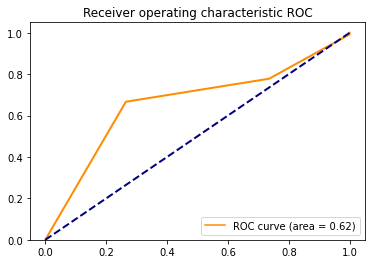

<Figure size 432x288 with 0 Axes>

In [ ]:
save_roc_curve_m(train_outputs, train_targets, path='.', label='roc',plot=True, pos_label=3)

## Metadata

In [ ]:
from torch.utils.data import DataLoader

aug_transform = transform_aug(params['im_size']) if params['augmentation'] else (None,None)

train_columns = ['sex', 'age_approx', 'anatom_site_general_challenge']

dataset = {
    'train': MelanomaDatasetMeta(train['path'], train[train_columns], train['target'], transform=aug_transform[0]),
    'val': MelanomaDatasetMeta(val['path'], val[train_columns], val['target'], transform=aug_transform[1])
}

train_loader = DataLoader(dataset['train'], batch_size=params['batch_size'], shuffle=True, pin_memory=True)
val_loader = DataLoader(dataset['val'], batch_size=params['batch_size'], pin_memory=True)

# images, meta, labels = next(iter(train_loader))
# images.shape, meta.shape, labels.shape

# Fit

In [ ]:
from tqdm import tqdm
import time

from timm.optim import AdamP
from timm.loss import BinaryCrossEntropy

train_loss, train_acc, train_f1, train_auc, val_loss, val_acc, val_f1, val_auc  = [], [], [], [], [], [], [], []
fit_lr = []
start = time.time()
best_=0

model = MelanomaClassifier(params['model'],n_class=4,pretrained=True)
# model = MelanomaClassifierMeta(params['model'],n_class=1,pretrained=True)
optimizer = AdamP(model.parameters(), lr=params['lr'])
# criterion = nn.BCEWithLogitsLoss()
criterion = nn.CrossEntropyLoss()
lr_scheduler = LRSchedulerPlateau(optimizer)
early_stopping = EarlyStopping()

model.to(params['device'])

for epoch in range(1, params["epochs"] + 1):
  train_epoch_loss, train_epoch_acc, train_epoch_f1, train_epoch_auc = fit(train_loader, model, criterion, optimizer, epoch, params)
  val_epoch_loss, val_epoch_acc, val_epoch_f1, val_epoch_auc = validate(val_loader, model, criterion, epoch, params) 
  train_loss.append(train_epoch_loss);train_acc.append(train_epoch_acc);train_f1.append(train_epoch_f1);train_auc.append(train_epoch_auc)
  val_loss.append(val_epoch_loss);val_acc.append(val_epoch_acc);val_f1.append(val_epoch_f1);val_auc.append(val_epoch_auc)
  if val_epoch_auc > best_:
    best_ = val_epoch_auc
    aug = 'aug' if params['augmentation'] else 'no_aug'
    torch.save(model, f'{PATH}/splits/{params["model"]}_{aug}.pth')
    print(f"Saving current best model: {best_:.3f}\n")

  if params['lr_scheduler']:
    lr_scheduler(val_epoch_loss)
  if params['early_stopping']:
    early_stopping(val_epoch_loss)
    if early_stopping.early_stop:
      break
  lr_ = get_lr(optimizer)
  fit_lr.append(lr_)
  print('learning rate:',lr_)
end = time.time()
print(f"Training time: {(end-start)/60:.3f} minutes")

In [ ]:
metrics = [(train_loss,val_loss), (train_acc,val_acc), (train_f1,val_f1), (train_auc,val_auc)]
names = ['loss', 'accuracy', 'f1', 'auc']
save_metrics(metrics, names, path=PATH, plot=False, mode='splits')
save_epoch_lr(fit_lr, lr_label= f'learning rate', path=PATH, plot=False, mode='splits')

# Define visuals

In [ ]:
import matplotlib.pyplot as plt

def save_epoch_lr(lr_list, lr_label, path, plot = False, mode='folds'):
    plt.figure(figsize=(7, 4))
    plt.plot(lr_list, color='red', label=lr_label)
    plt.xlabel('epochs')
    plt.ylabel(lr_label)
    plt.legend()
    plt.savefig(f"{path}/{mode}/{lr_label}.png")
    plt.show() if plot else plt.close()
    

In [ ]:
import matplotlib.pyplot as plt

def save_metrics(metric_list, labels_list, path, fold=None, plot=False, mode='folds'):
  for i in range(len(labels_list)):
    plt.figure(figsize=(7, 4))
    plt.plot(metric_list[i][0], color='green', label=f'train {labels_list[i]}')
    plt.plot(metric_list[i][1], color='orange', label=f'validataion {labels_list[i]}')
    plt.xlabel('epochs')
    plt.ylabel(labels_list[i])
    plt.legend()
    if mode=='folds':
      plt.savefig(f"{path}/{mode}/fold{fold}_{labels_list[i]}.png")
    else:
      plt.savefig(f"{path}/{mode}/{labels_list[i]}.png")
    plt.show() if plot else plt.close()

## Examples

In [ ]:
import matplotlib.pyplot as plt

lr_label= 'learning rate'
plt.figure(figsize=(7, 4))
plt.plot(fit_lr, color='red', label=lr_label)
plt.xlabel('epochs')
plt.ylabel(lr_label)
plt.legend()
plt.savefig(f"./{lr_label}.png")
plt.show()

In [ ]:
import matplotlib.pyplot as plt

metrics = [(train_loss,val_loss), (train_acc,val_acc), (train_f1,val_f1), (train_auc,val_auc)]
names = ['loss', 'accuracy', 'f1', 'auc']
for i in range(len(names)):
  plt.figure(figsize=(7, 4))
  plt.plot(metrics[i][0], color='green', label=f'train {names[i]}')
  plt.plot(metrics[i][1], color='orange', label=f'validataion {names[i]}')
  plt.xlabel('epochs')
  plt.ylabel(names[i])
  plt.legend()
  plt.savefig(f"./{names[i]}.png")
  plt.show()

## Kfold fit

#### Define function to extract folds from training data

In [ ]:
def get_folds(df, fold):
  '''
  Return training and validation dataframe for specific fold
  df: Whole training + validation dataset
  fold: Specific fold index
  '''
  df_train = df[df.kfold != fold].reset_index(drop=True)
  df_valid = df[df.kfold == fold].reset_index(drop=True)
  return df_train, df_valid

In [ ]:
from tqdm import tqdm
import time


from timm.optim import AdamP
from timm.loss import BinaryCrossEntropy

train_loss, train_acc, train_f1, train_auc, val_loss, val_acc, val_f1, val_auc  = [], [], [], [], [], [], [], []
start = time.time()

aug_transform = transform_aug(params['im_size']) if params['augmentation'] else (None,None)

for fold in range(params['folds']):
  best_ = 0
  fit_lr = []
  model = MelanomaClassifier(params['model'],n_class=1,pretrained=True)
  model.to(params['device'])
  optimizer = AdamP(model.parameters(), lr=params['lr'])
  criterion = nn.BCEWithLogitsLoss()
  lr_scheduler = LRSchedulerPlateau(optimizer)
  early_stopping = EarlyStopping()
  train_fold, val_fold = get_folds(train,fold)
  train_loader, val_loader = data_loader(train_fold, val_fold, transform_tuple= aug_transform, batch_size=params['batch_size'])
  for epoch in range(1, params["epochs"] + 1):
    lr_ = get_lr(optimizer)
    fit_lr.append(lr_)
    print('\nLearning rate:',lr_)

    train_epoch_loss, train_epoch_acc, train_epoch_f1, train_epoch_auc = fit(train_loader, model, criterion, optimizer, epoch, params)
    print(f'\nOverall Training. Loss: {train_epoch_loss:.3f}, Accuracy: {train_epoch_acc:.3f}, F1: {train_epoch_f1:.3f}, AUC: {train_epoch_auc:.3f}\n') 
    val_epoch_loss, val_epoch_acc, val_epoch_f1, val_epoch_auc = validate(val_loader, model, criterion, epoch, params)
    print(f'\nOverall Validation. Loss: {val_epoch_loss:.3f}, Accuracy: {val_epoch_acc:.3f}, F1: {val_epoch_f1:.3f}, AUC: {val_epoch_auc:.3f}\n')   
    train_loss.append(train_epoch_loss);train_acc.append(train_epoch_acc);train_f1.append(train_epoch_f1);train_auc.append(train_epoch_auc)
    val_loss.append(val_epoch_loss);val_acc.append(val_epoch_acc);val_f1.append(val_epoch_f1);val_auc.append(val_epoch_auc)
    
    if val_epoch_auc > best_:
      best_ = val_epoch_auc
      aug = 'aug' if params['augmentation'] else 'no_aug'
      torch.save(model, f'{PATH}/folds/fold{fold+1}_{params["model"]}_{aug}.pth')
      print(f"Saving current best model for fold {fold+1}: {best_:.3f}\n")

    if params['lr_scheduler']:
      lr_scheduler(val_epoch_loss)
    if params['early_stopping']:
      early_stopping(val_epoch_loss)
      if early_stopping.early_stop:
        break
    if epoch ==5:
      break
  metrics = [(train_loss,val_loss), (train_acc,val_acc), (train_f1,val_f1), (train_auc,val_auc)]
  names = ['loss', 'accuracy', 'f1', 'auc']
  save_metrics(metrics, names, fold=fold+1, path=PATH, plot=False)
  save_epoch_lr(fit_lr, lr_label= f'Fold{fold+1}_learning rate', path=PATH, plot=False)

end = time.time()
print(f"Training time: {(end-start)/60:.3f} minutes")

# Show batch

In [ ]:
def denormalize(images, means, stds):
    means = torch.tensor(means).reshape(1, 3, 1, 1)
    stds = torch.tensor(stds).reshape(1, 3, 1, 1)
    return images * stds + means

In [ ]:
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
def show_batch(data_loader, denormalize_=False, train_batch=True):
    for batch in data_loader:
      if train_batch:
        images, _ = batch
      else:
        images = batch 
      fig, ax = plt.subplots(figsize=(16, 8))
      ax.set_xticks([]); ax.set_yticks([])
      if denormalize_:
        denorm_images = denormalize(images, mean, std)
        images = denorm_images
      ax.imshow(make_grid(images, nrow=8).permute(1, 2, 0))
      break

## Meta show_batch

In [ ]:
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
def show_batch_meta(data_loader, denormalize_=False, train_batch=True):
    for batch in data_loader:
      if train_batch:
        images, _, _ = batch
      else:
        images, _ = batch 
      fig, ax = plt.subplots(figsize=(16, 8))
      ax.set_xticks([]); ax.set_yticks([])
      if denormalize_:
        denorm_images = denormalize(images, mean, std)
        images = denorm_images
      ax.imshow(make_grid(images, nrow=8).permute(1, 2, 0))
      break

In [ ]:
from torch.utils.data import DataLoader

aug_transform = transform_aug(params['im_size']) if params['augmentation'] else (None,None)

train_columns = ['sex', 'age_approx', 'anatom_site_general_challenge']

dataset = {
    'train': MelanomaDataset(train['path'], train[train_columns], train['target'], transform=aug_transform[0]),
    'val': MelanomaDataset(val['path'], val[train_columns], val['target'], transform=aug_transform[1])
}

train_loader = DataLoader(dataset['train'], batch_size=params['batch_size'], shuffle=True, pin_memory=True)
val_loader = DataLoader(dataset['val'], batch_size=params['batch_size'], pin_memory=True)

images, meta, labels = next(iter(train_loader))
images.shape, meta.shape, labels.shape
# show_batch_meta(train_loader)

## Hold-out split visuals

In [ ]:
aug_transform = transform_aug(params['im_size'])

train_loader, val_loader = data_loader(train, val, transform_tuple= aug_transform, batch_size= params['batch_size'])
show_batch(train_loader, denormalize_ = True)
# show_batch(val_loader, denormalize_ = True)

## Folds visuals

In [ ]:
# aug_transform = transform_aug(params['im_size'])

# for fold in range(KFOLD):
#   train_fold, val_fold = get_folds(train,fold)
#   train_loader, val_loader = data_loader(train_fold, val_fold, transform_tuple= aug_transform, batch_size= params['batch_size'])
#   images, labels = next(iter(train_loader))
#   show_batch(train_loader, denormalize_ = True)
#   show_batch(val_loader, denormalize_ = True)
  

In [ ]:
# show_batch(train_loader, denormalize_ = True)

# Test

## Load Test csv

In [ ]:
test_csv = f'{PATH}/test_path.csv'
test = pd.read_csv(test_csv)
test.shape

In [ ]:
from torch.utils.data import DataLoader

test_dataset = MelanomaDataset(test['path'], train=False)
test_loader = DataLoader(test_dataset, batch_size=params['batch_size'])
images = next(iter(test_loader))
images.shape

### Meta

In [ ]:
test_csv = f'{PATH}/test_meta.csv'
test = pd.read_csv(test_csv)
test.shape
test = test.astype({"age_approx": 'str'})

test.rename(columns={'anatom_site_general':'anatom_site_general_challenge'}, inplace=True)

In [ ]:
from torch.utils.data import DataLoader
test_columns = ['sex', 'age_approx', 'anatom_site_general_challenge']

test_dataset = MelanomaDatasetMeta(test['path'], test[test_columns], train=False)
test_loader = DataLoader(test_dataset, batch_size=params['batch_size'], pin_memory=True)
# images, meta = next(iter(test_loader))
# images.shape, meta.shape
# show_batch_meta(test_loader, train_batch=False)

In [ ]:
import pandas as pd
sub = f'{PATH}/submission.csv'

submission = pd.read_csv(sub)

In [ ]:
out = submission.target.to_frame()
out = torch.tensor(out.target.values)
out = torch.sigmoid(out)
out

In [ ]:
submission

## Hold-out split

In [ ]:
from tqdm import tqdm
from sklearn.metrics import classification_report, confusion_matrix
import time
start = time.time()

PATH = params['path']
aug = 'aug' if params['augmentation'] else 'no_aug'
model_name=params['model']

model = torch.load(f'{PATH}/splits/{model_name}_{aug}.pth',map_location=torch.device(params['device']))
model.to(params['device'])
model.eval()
preds = torch.tensor([]).to(params['device'])
val_outputs = torch.tensor([])
val_targets = torch.tensor([])
stream = tqdm(test_loader)
metric_monitor = MetricMonitor()

test_targets_exist = params['targets_exist']

with torch.no_grad():
  for i, batch in enumerate(stream, start=1):
    if test_targets_exist:
      imgs, targets = batch
      imgs, targets = imgs.to(params['device']), targets.to(params['device'])
      outputs = model(imgs)
      preds = torch.cat([preds, outputs.view(-1)])
      val_outputs = torch.cat([val_outputs, outputs.cpu()])
      val_targets = torch.cat([val_targets, targets.cpu()])
      accuracy = accuracy_score(val_outputs, val_targets)
      auc = auc_score(val_outputs, val_targets)
      f1 = f1_score_(val_outputs, val_targets)
      metric_monitor.update("Accuracy", accuracy)
      metric_monitor.update("F1", f1)
      metric_monitor.update("AUC", auc)
      stream.set_description("Test. {metric_monitor}".format(metric_monitor=metric_monitor))
    else:
      imgs = batch
      imgs = imgs.to(params['device'])
      outputs = model(imgs)
      preds = torch.cat([preds, outputs.view(-1)])
      val_outputs = torch.cat([val_outputs, outputs.cpu()])
print('INFO: Test completed')
if test_targets_exist:
  accuracy = accuracy_score(val_outputs, val_targets)
  recall_s = recall_scr(val_outputs, val_targets, pos_label=1)
  auc = auc_score(val_outputs, val_targets)
  f1 = f1_score_(val_outputs, val_targets)
  print(f'\nOverall Test. Accuracy: {accuracy:.3f}, F1: {f1:.3f}, AUC: {auc:.3f}, Recall: {recall_s:.3f}\n')
else:
  submission = pd.DataFrame({'image_name': test['image'].values, 'target': preds.cpu().numpy()})
  submission.to_csv(f'{PATH}/submission.csv', index=False)
end = time.time()
print(f"\nTest time: {(end-start)/60:.3f} minutes")

### ROC | Classification report

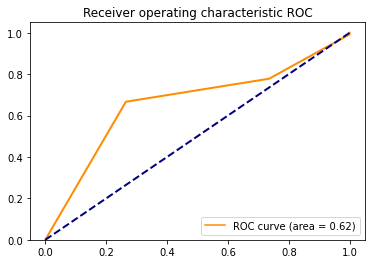

              precision    recall  f1-score   support

         UNK       0.00      0.00      0.00         1
          NV       0.00      0.00      0.00        36
         MEL       0.48      0.47      0.47        30
         BKL       0.67      0.90      0.77        93

    accuracy                           0.61       160
   macro avg       0.29      0.34      0.31       160
weighted avg       0.48      0.61      0.53       160



<Figure size 432x288 with 0 Axes>

In [ ]:
from sklearn.metrics import classification_report
from matplotlib import pyplot as plt
model_name= params['model']

save_roc_curve_m(val_outputs, val_targets, path=PATH, label=f'ROC {model_name}', plot=True, pos_label=3)

o = val_outputs.cpu()
o = nn.functional.softmax(o, dim=1)
_, o = torch.max(o, dim = 1)  
o = o.detach().numpy()
t = val_targets.cpu().detach().numpy()
plot_labels = ['UNK', 'NV', 'MEL', 'BKL']

report = classification_report(o, t, target_names=plot_labels)
print(report)


### Confusion matrix

In [ ]:
def save_confusion_matrix_m(outputs, targets, path, label, classes=None, plot=False, percentage=True):
  model_name= params['model']
  o = val_outputs.cpu()
  o = nn.functional.softmax(o, dim=1)
  _, o = torch.max(o, dim = 1)  
  o = o.detach().numpy()
  t = val_targets.cpu().detach().numpy()
  cf_matrix = confusion_matrix(t, o)
  df_cm = pd.DataFrame(cf_matrix/np.sum(cf_matrix) if percentage else cf_matrix, index = [i for i in classes], columns = [i for i in classes])
  sn.heatmap(df_cm, annot=True, cmap='Blues')
  plt.title(f'{label} Confusion Matrix')
  plt.savefig(f'{path}/{label}_cm.png')
  plt.show() if plot else plt.close()
  plt.clf()

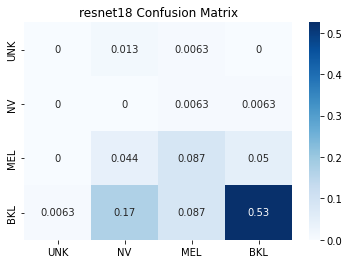

<Figure size 432x288 with 0 Axes>

In [ ]:
classes = ('UNK', 'NV', 'MEL', 'BKL')
model_name= params['model']
save_confusion_matrix_m(train_outputs, train_targets, path=PATH, label=model_name, classes=classes, plot = True, percentage = True)

### Meta split with hold-out split

In [ ]:
from tqdm import tqdm
from sklearn.metrics import classification_report, confusion_matrix
import time
start = time.time()

PATH = params['path']
aug = 'aug' if params['augmentation'] else 'no_aug'
model_name=params['model']

model = torch.load(f'{PATH}/splits/{model_name}_{aug}.pth',map_location=torch.device(params['device']))
model.to(params['device'])
model.eval()
preds = torch.tensor([]).to(params['device'])
val_outputs = torch.tensor([])
val_targets = torch.tensor([])
stream = tqdm(test_loader)
metric_monitor = MetricMonitor()

test_targets_exist = params['targets_exist']

with torch.no_grad():
  for i, batch in enumerate(stream, start=1):
    imgs, meta = batch
    imgs, meta = imgs.to(params['device']), meta.to(params['device'])
    outputs = model(imgs, meta)
    preds = torch.cat([preds, outputs.view(-1)])
    val_outputs = torch.cat([val_outputs, outputs.cpu()])
print('INFO: Test completed')
if test_targets_exist:
  accuracy = accuracy_score(val_outputs, val_targets)
  recall_s = recall_scr(val_outputs, val_targets, pos_label=1)
  auc = auc_score(val_outputs, val_targets)
  f1 = f1_score_(val_outputs, val_targets)
  print(f'\nOverall Test. Accuracy: {accuracy:.3f}, F1: {f1:.3f}, AUC: {auc:.3f}, Recall: {recall_s:.3f}\n')
else:
  submission = pd.DataFrame({'image_name': test['image'].values, 'target': preds.cpu().numpy()})
  submission.to_csv(f'{PATH}/submission.csv', index=False)
end = time.time()
print(f"\nTest time: {(end-start)/60:.3f} minutes")

## Folds

In [ ]:
from tqdm import tqdm
from sklearn.metrics import classification_report, confusion_matrix
start = time.time()

acc_predict_folds = []
auc_predict_folds = []
f1_predict_folds = []
val_outputs_folds = []
preds_folds = []
for fold in range(params['folds']):
  model = torch.load(f'{PATH}/folds/fold{fold+1}_resnet18_no_aug.pth',map_location=torch.device(params['device']))
  model.to(params['device'])
  model.eval()
  preds = torch.tensor([]).to(params['device'])
  val_outputs = torch.tensor([])
  val_targets = torch.tensor([])
  stream = tqdm(test_loader)
  metric_monitor = MetricMonitor()
  with torch.no_grad():
    for i, batch in enumerate(stream, start=1):
      imgs, targets = batch
      imgs, targets = imgs.to(params['device']), targets.to(params['device'])
      outputs = model(imgs)
      preds = torch.cat([preds, outputs.view(-1)])
      val_outputs = torch.cat([val_outputs, outputs.cpu()])
      val_targets = torch.cat([val_targets, targets.cpu()])
      accuracy = accuracy_score(val_outputs, val_targets)
      auc = auc_score(val_outputs, val_targets)
      f1 = f1_score_(val_outputs, val_targets)
      metric_monitor.update("Accuracy", accuracy)
      metric_monitor.update("F1", f1)
      metric_monitor.update("AUC", auc)
      stream.set_description("Test. {metric_monitor}".format(metric_monitor=metric_monitor))
  val_outputs_folds.append(val_outputs)
  preds_folds.append(preds.cpu().numpy())
  accuracy = accuracy_score(val_outputs, val_targets)
  recall_s = recall_scr(val_outputs, val_targets, pos_label=1)
  auc = auc_score(val_outputs, val_targets)
  f1 = f1_score_(val_outputs, val_targets)
  acc_predict_folds.append(accuracy)
  auc_predict_folds.append(auc)
  f1_predict_folds.append(f1)
  print(f'\nOverall Fold {fold+1} test results. Accuracy: {accuracy:.3f}, F1: {f1:.3f}, AUC: {auc:.3f}, Recall: {recall_s:.3f}\n\n')
print('INFO: Test completed')
preds_fold_mean = np.mean(preds_folds, axis =0)
acc_avg = np.mean(acc_predict_folds, axis=0)
auc_avg = np.mean(auc_predict_folds, axis=0)
f1_avg = np.mean(f1_predict_folds, axis=0)
print(f'\nAverage test results for all folds. Accuracy: {acc_avg:.3f}, F1: {f1_avg:.3f}, AUC: {auc_avg:.3f}\n')
end = time.time()
print(f"\nTest time: {(end-start)/60:.3f} minutes")

### ROC | Classification report

In [ ]:
from sklearn.metrics import classification_report
from matplotlib import pyplot as plt

model_name= params['model']

val_outputs = train_outputs
val_targets = train_targets

plot_labels = ['UNK', 'NV', 'MEL', 'BKL']
for fold in range(params['folds']):
  save_roc_curve(val_outputs_folds[fold], val_targets, path=PATH, label=f'ROC {model_name}', plot=True, pos_label=3)
  o = val_outputs[fold].cpu()
  o = nn.functional.softmax(o, dim=1)
  _, o = torch.max(o, dim = 1)  
  o = o.detach().numpy()
  t = val_targets[fold].cpu().detach().numpy()
  report = classification_report(o, t, target_names=plot_labels)
  print(report)

### Confusion Matrix

In [ ]:
classes = ('UNK', 'NV', 'MEL', 'BKL')
model_name= params['model']
for fold in range(params['folds']):
  save_confusion_matrix_m(val_outputs_folds[fold], val_targets, path=PATH, label=model_name+f'_fold_{fold+1}', classes=classes, plot = True, percentage = True)

# Ensamble

## With submissions

In [ ]:
sub_dir = PATH+'/submissions/'
sub_dir

'/content/drive/MyDrive/ISIC/2020/submissions/'

In [ ]:
from glob import glob
subs = [pd.read_csv(csv) for csv in sorted(glob(os.path.join(sub_dir, '*csv')))]
sub_probs = [sub.target.rank(pct=True).values for sub in subs]

(10982, 2)

In [ ]:
wts = [1/(len(sub_probs))]*(len(sub_probs))
assert len(wts)==len(sub_probs)
sub_ens = np.sum([wts[i]*sub_probs[i] for i in range(len(wts))],axis=0)

df_sub = subs[0]
df_sub['target'] = sub_ens
df_sub.to_csv(f"final_sub1.csv",index=False)


In [ ]:
df_sub.shape

(10982, 2)